# Sphere test
Generating spherical slices for cutting

In [1]:
%matplotlib inline

from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image, ImageFilter, ImageDraw

## Generate test data

Helper functions: Draw large sphere with a smaller, concentric cutout

$ (x - a)² + (y - b)² + (z - c)² = r² $

In [2]:
def make_sphere(container_size, radius):

    idx = np.arange(0, container_size)
    center = np.median(idx)

    _x = idx
    _y = idx
    _z = idx
    x, y, z = np.meshgrid(_x, _y, _z, indexing='ij')
    
    sphere = (x-center)**2+(y-center)**2+(z-center)**2 <= radius**2
    sphere = sphere*1
    return sphere

In [3]:
big_sphere = make_sphere(71*5, 62/2*5)
little_sphere = make_sphere(71*5, 62/4*5)
composed_sphere = big_sphere-little_sphere

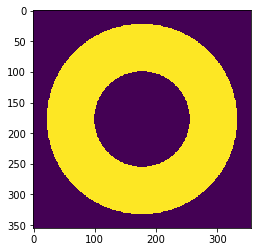

In [4]:
test_slice = composed_sphere[:,:,int(71*5/2)]
plt.imshow(test_slice)

Select slices for laser cutting:

In [5]:
slices_to_print = np.linspace(30,71*5-30,7).astype(int)
print(slices_to_print)

[ 30  79 128 177 226 275 325]


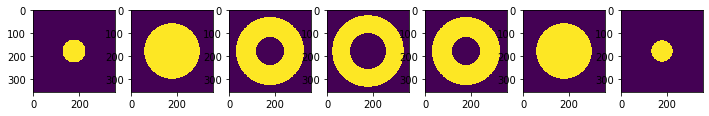

In [6]:
f, ax = plt.subplots(1, 7, figsize=(12,3))
for axi,i in zip(ax,slices_to_print):
    axi.imshow(composed_sphere[:,:,i])

In [7]:
print_slices = composed_sphere[:,:,slices_to_print]
print_shape = np.shape(print_slices)

print(print_shape)

(355, 355, 7)


## Image processing

Turn a binary array into a mask image:

In [8]:
def arr2img(arr):
    
    # Select slice
    arr_neg = (1-arr)*255
    arr_3d = np.expand_dims(arr,2)
    
    # Image data
    arr_rgba = np.ones(np.shape(arr) + (4,))*255.0
    arr_rgba[:,:,1] = arr_neg
    arr_rgba[:,:,2] = arr_neg
    arr_rgba = arr_rgba.astype('uint8')
    
    # Output image
    arr_img = Image.fromarray(arr_rgba, mode='RGBA')
    return arr_img

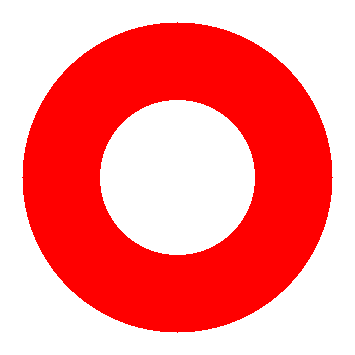

In [9]:
test_image = arr2img(test_slice)
display(test_image)

Detect contours in mask image:

In [10]:
def mask2contour(mask_img):
    
    contour_img = mask_img.filter(ImageFilter.CONTOUR)
    
    return contour_img

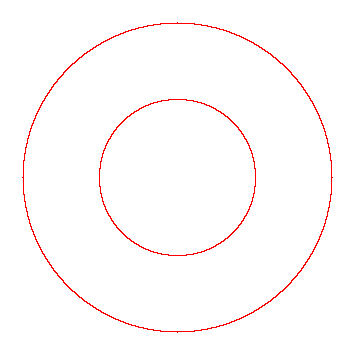

In [11]:
test_contour = mask2contour(test_image)
display(test_contour)

Add rectangular base to slice:

In [12]:
def add_base(arr):
    w,h = np.shape(arr)

    # Fill inner hole
    arr_filled = ndimage.binary_fill_holes(arr)

    # Find horizontal bounds
    circle_horiz = np.sum(arr, axis=1)
    circle_horiz_coords = np.where(circle_horiz > 0)[0]
    circle_diameter = circle_horiz_coords[-1]-circle_horiz_coords[0]
    base_width = int(circle_diameter*.5)
    offset = int((w-base_width)/2)

    # Bounding box
    x0 = offset
    x1 = w-offset

    y0 = np.where(arr_filled[:,x0])[0][-1]
    y1 = h

    # Draw rectangle
    rect_arr = np.zeros((w,h))
    rect_arr[y0:y1, x0:x1] = 1

    # Slice + base
    base = (arr + rect_arr) > 0
    base = base*1
    
    return rect_arr, base

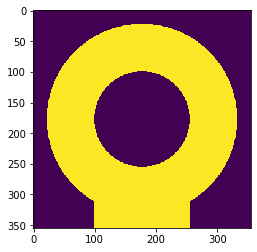

In [13]:
test_rect, test_base = add_base(test_slice)
plt.imshow(test_base)

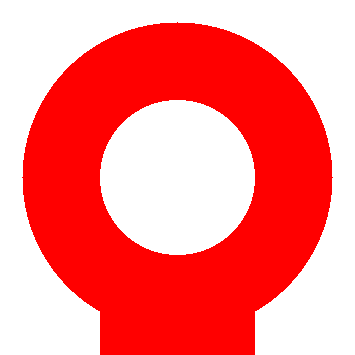

In [14]:
test_base_img = arr2img(test_base)
display(test_base_img)

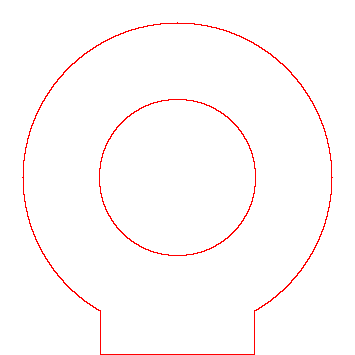

In [15]:
test_base_contour = mask2contour(test_base_img)
display(test_base_contour)

Helper function: Image back to binary array

In [16]:
def image2arr(img):
    
    img_copy = img.copy()
    img_data = np.array(img_copy)
    
    img_mult = np.prod(img_data, axis=2)
    img_bin = (img_mult > 0)*1
    img_neg = 1-img_bin
    
    return img_neg

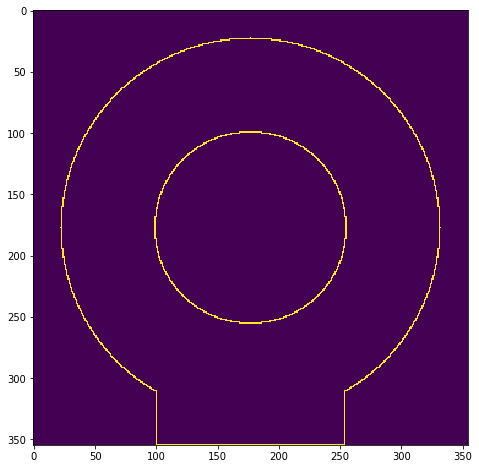

In [17]:
test_arr = image2arr(test_base_contour)
plt.figure(figsize=(8,8))
plt.imshow(test_arr)

Engrave whatever slice contours intersect with the base:

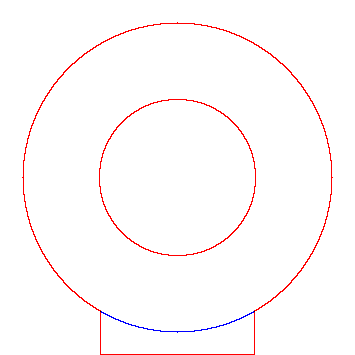

In [19]:
contour_img = test_contour
base_img = test_base_contour
base_rect = test_rect

# Convert slice, slice+base images into arrays
contour_arr = image2arr(contour_img)
base_arr = image2arr(base_img)

# Get outlines that are within slice
inner_contours = (1-contour_arr*base_rect)
outer_contours = (1-base_arr)

# Color outer contours (cut) red, inner contours (engrave) blue
cut_arr = np.ones(np.shape(base_img))
cut_arr[:,:,0] = inner_contours
cut_arr[:,:,1] = inner_contours * outer_contours
cut_arr[:,:,2] = outer_contours
cut_arr[:,:,3] = (2-inner_contours-outer_contours) > 0

cut_arr = cut_arr*255.0
cut_arr = cut_arr.astype('uint8')

cut_img = Image.fromarray(cut_arr, mode='RGBA')
display(cut_img)